<a href="https://colab.research.google.com/github/chiyeon01/Hands_On_Machine_Learning/blob/main/8.%20%EC%B0%A8%EC%9B%90_%EC%B6%95%EC%86%8C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 주성분 분석

## Principal Components

In [1]:
import numpy as np
from scipy.spatial.transform import Rotation

m = 60
X = np.zeros((m, 3))  # 3D 데이터 초기화
np.random.seed(42)
angles = (np.random.rand(m) ** 3 + 0.5) * 2 * np.pi  # 고르지 않은 분포
X[:, 0], X[:, 1] = np.cos(angles), np.sin(angles) * 0.5  # 타원형
X += 0.28 * np.random.randn(m, 3)  # 노이즈 추가
X = Rotation.from_rotvec([np.pi / 29, -np.pi / 20, np.pi / 4]).apply(X)
X += [0.2, 0, 0.2]  # 약간 이동

X_centered = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)
c1 = Vt[0]
c2 = Vt[1]

## d차원으로 투영하기

In [4]:
W2 = Vt[:2].T
X2D = X_centered @ W2

## 사이킷런 사용하기

In [7]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X2D = pca.fit_transform(X)

In [9]:
# 처음 d개의 주성분
pca.components_

array([[ 0.67857588,  0.70073508,  0.22023881],
       [ 0.72817329, -0.6811147 , -0.07646185]])

## 설명된 분산의 비율

In [10]:
pca.explained_variance_ratio_

array([0.7578477 , 0.15186921])

## 적절한 차원 수 선택

In [11]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml("mnist_784", as_frame=False)
X_train, y_train = mnist.data[:60_000], mnist.target[:60_000]
X_test, y_test = mnist.data[60_000:], mnist.target[60_000:]

pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1

In [12]:
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_train)

In [15]:
pca.n_components_, d

(np.int64(154), np.int64(154))

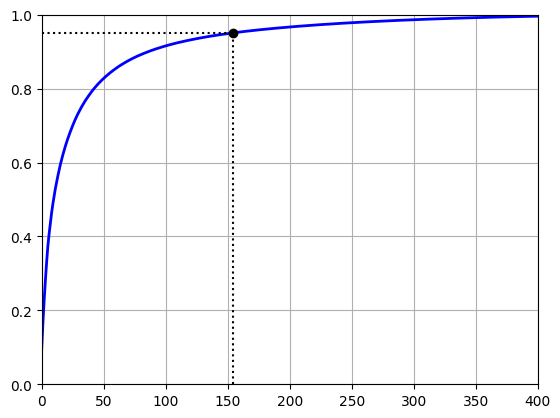

In [36]:
import matplotlib.pyplot as plt

plt.plot([i for i in range(cumsum.shape[0])], cumsum, "b-", linewidth=2)
plt.plot(d, cumsum[d-1], "ko")
plt.plot([d, d], [0, cumsum[d-1]], "k:")
plt.plot([0, d], [cumsum[d-1], cumsum[d-1]], "k:")
plt.grid(True)
plt.axis([0, 400, 0, 1])
plt.show()

In [37]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import make_pipeline

clf = make_pipeline(
    PCA(random_state=42),
    RandomForestClassifier(random_state=42)
)

param_distrib = {
    "pca__n_components": np.arange(10, 80),
    "randomforestclassifier__n_estimators": np.arange(50, 500)
}

rnd_search = RandomizedSearchCV(
    clf,
    param_distrib,
    n_iter=10,
    cv=3,
    random_state=42
)

rnd_search.fit(X_train[:1000], y_train[:1000])

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('pca', PCA(random_state=42)),
                                             ('randomforestclassifier',
                                              RandomForestClassifier(random_state=42))]),
                   param_distributions={'pca__n_components': array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
       27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43,
       44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60,
       6...
       414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426,
       427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439,
       440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452,
       453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465,
       466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478,
       479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491,
       492, 493, 494, 495, 496, 497, 498, 499])},
                   random_state=42)

In [38]:
print(rnd_search.best_params_)

{'randomforestclassifier__n_estimators': np.int64(475), 'pca__n_components': np.int64(57)}


In [39]:
X_recovered = pca.inverse_transform(X_reduced)

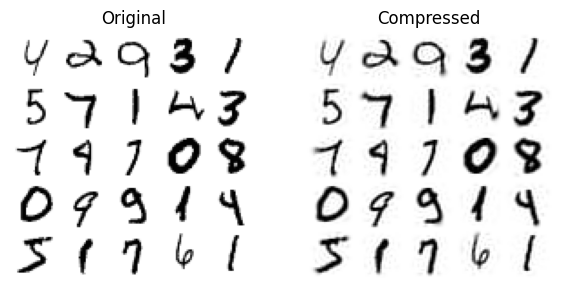

In [40]:
plt.figure(figsize=(7, 4))
for idx, X in enumerate((X_train[::2100], X_recovered[::2100])):
    plt.subplot(1, 2, idx + 1)
    plt.title(["Original", "Compressed"][idx])
    for row in range(5):
        for col in range(5):
            plt.imshow(X[row * 5 + col].reshape(28, 28), cmap="binary",
                       vmin=0, vmax=255, extent=(row, row + 1, col, col + 1))
            plt.axis([0, 5, 0, 5])
            plt.axis("off")

## 랜덤 PCA

In [41]:
rnd_pca = PCA(n_components=154, svd_solver="randomized", random_state=42)
X_reduced = rnd_pca.fit(X_train)

## 점진적 PCA(IPCA)

In [42]:
from sklearn.decomposition import IncrementalPCA

n_batches = 100
inc_pca = IncrementalPCA(n_components=154)
for X_batch in np.array_split(X_train, n_batches):
    inc_pca.partial_fit(X_batch)

X_reduced = inc_pca.transform(X_train)

# 랜덤 투영

In [43]:
from sklearn.random_projection import johnson_lindenstrauss_min_dim

m, e = 5_000, 0.1
d = johnson_lindenstrauss_min_dim(m, eps=e)

In [44]:
d

np.int64(7300)

In [45]:
n = 20_000
np.random.seed(42)
P = np.random.randn(d, n) / np.sqrt(d)

X = np.random.randn(m, n)
X_reduced = X @ P.T

In [46]:
from sklearn.random_projection import GaussianRandomProjection

gaussian_rnd_proj = GaussianRandomProjection(eps=e, random_state=42)
X_reduced = gaussian_rnd_proj.fit_transform(X)

In [47]:
components_pinv = np.linalg.pinv(gaussian_rnd_proj.components_)
X_recovered = X_reduced @ components_pinv.T

# 지역 선형 임베딩

In [49]:
from sklearn.datasets import make_swiss_roll
from sklearn.manifold import LocallyLinearEmbedding

X_swiss, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)
lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10, random_state=42)
X_unrolled = lle.fit_transform(X_swiss)